## Equation 
The equation we are testing is

$$
\begin{cases}
u'(x) + u(x) = x, \qquad\text{for}\; 0<x<1,\\
u(0) = 1.
\end{cases}
$$ 

The exact solution is
$$ u^*(x) = x-1+2e^{-x}.$$



---

The idea of the paper is, assume $$u = \mathrm{NN}(x).$$
We minimize the loss function
$$ L(\hat{u}) = \mathrm{Mean}\left(\left\Vert \frac{d\hat{u}}{dx} + \hat{u} -x\right\Vert^2\right) + |\hat{u}(0)-1|^2 $$
where all the derivatives are computed via 
* back-propagation - we tried this idea but it does not work well, maybe autograd in Pytorch does not perform it well, or the idea behind it is problematic, in the sense that the derivative obtained by back-propagation with second-order is not very nice.
* finite difference scheme

In [1]:
# Import libraries
import numpy as np
import math
from numpy import linalg
import pandas as pd
# !pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

import torch.nn.init as init
from torch import autograd

from torch import nn, optim
from time import time

In [3]:
def u_star_func(x):
    result = x-1+2*np.exp(-x)
    return result

import matplotlib.pyplot as plt
def draw_result(lst_iter, lst_loss, title='Loss'):
    plt.plot(lst_iter, lst_loss, '-b', label='loss')
    
    plt.xlabel("n iteration")
    plt.legend(loc='upper left')
    plt.title(title)
    plt.savefig(title +".png")  # should before show method

    # show
    plt.show()

# plt.plot(test_error_vec)
# plt.show()


def draw_graph(lst_iter, lst_loss, lst_acc, title):
    plt.plot(lst_iter, lst_loss, '-b', label='true solution')
    plt.plot(lst_iter, lst_acc, '-r', label='PINNs')

    plt.xlabel("x")
    plt.legend(loc='upper left')
    plt.title(title)
    plt.savefig(title+".png")  # should before show method
    plt.show()

## Backpropagation

In [5]:
input_size = 1
output_size = 1
k = 16
model = nn.Sequential(nn.Linear(input_size, k),
                      nn.Tanh(),

                      nn.Linear(k, k),
                      nn.Tanh(),

                      nn.Linear(k, k),
                      nn.Tanh(),
                      
                      nn.Linear(k, output_size),
                      nn.Tanh(),
                      )
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=16, bias=True)
  (5): Tanh()
  (6): Linear(in_features=16, out_features=1, bias=True)
  (7): Tanh()
)


In [4]:
# Discritize the interval
a = 0
b = 1
step = (b-a)/100
x_init_np = np.arange(start=a, stop=b+step, step=step)

In [13]:
x_init_np

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

In [6]:
x_init_np = x_init_np[1:-1]
x_init = torch.tensor(x_init_np, requires_grad= True)
# print(x_init)
print(x_init.shape)

torch.Size([99])


The running loss at 0 iteration is: 0.5926810503005981
The running loss at 1 iteration is: 0.3285556733608246
The running loss at 2 iteration is: 0.17291365563869476
The running loss at 3 iteration is: 0.07443434000015259
The running loss at 4 iteration is: 0.020480774343013763
The running loss at 5 iteration is: 0.015170485712587833
The running loss at 6 iteration is: 0.02991272322833538
The running loss at 7 iteration is: 0.0261674914509058
The running loss at 8 iteration is: 0.009324283339083195
The running loss at 9 iteration is: 0.003187241731211543
The running loss at 10 iteration is: 0.014298014342784882
The running loss at 11 iteration is: 0.021091323345899582
The running loss at 12 iteration is: 0.013211849145591259
The running loss at 13 iteration is: 0.003105700481683016
The running loss at 14 iteration is: 0.004260072484612465
The running loss at 15 iteration is: 0.012134197168052197
The running loss at 16 iteration is: 0.012848306447267532
The running loss at 17 iteration 

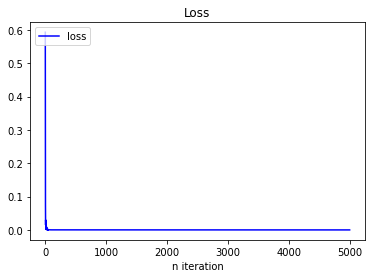

The running loss at 5000 iteration is: 5.1465482101775706e-05


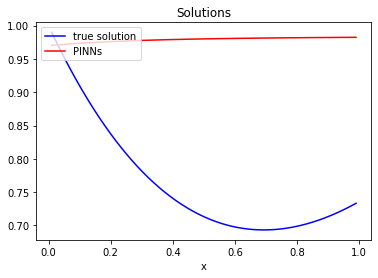

In [7]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
time0 = time()
num_e = 5000
iter = []
test_error_vec = []
scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)
scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200], gamma=0.1)
for e in range(num_e):
    running_loss = 0
    # call zero_Grad
    optimizer.zero_grad() 
    # Compute u_hat, d2u_hat
    u_hat = torch.tensor(np.array([]))
    du_dx = torch.tensor(np.array([]))
    for xi in x_init_np:
        x_tensor = torch.tensor([xi], requires_grad=True)
        temp = model(x_tensor.float())
        u_hat = torch.hstack([u_hat, temp])
        deri = autograd.grad(model(x_tensor.float()), x_tensor, create_graph=True)[0]
        du_dx = torch.hstack([du_dx, deri])
    loss = torch.mean((du_dx + u_hat - x_tensor)**2) + (model(torch.tensor([0.])-1))**2
    loss.backward()
    optimizer.step() 
    scheduler2.step()

    running_loss += loss.clone().item()    
    
    print(f"The running loss at {e} iteration is: {running_loss}")
    test_error_vec.append(running_loss)
    iter.append(e)

draw_result(iter, test_error_vec)
print(f"The running loss at {num_e} iteration is: {test_error_vec[-1]}")
y_true = u_star_func(x_init_np)
draw_graph(x_init_np, y_true, u_hat.clone().detach().numpy(), 'Solutions')

In [8]:
u_hat

tensor([0.9703, 0.9707, 0.9711, 0.9715, 0.9719, 0.9722, 0.9726, 0.9729, 0.9732,
        0.9735, 0.9738, 0.9741, 0.9744, 0.9746, 0.9749, 0.9751, 0.9754, 0.9756,
        0.9758, 0.9760, 0.9762, 0.9764, 0.9766, 0.9768, 0.9770, 0.9772, 0.9773,
        0.9775, 0.9777, 0.9778, 0.9780, 0.9781, 0.9782, 0.9784, 0.9785, 0.9786,
        0.9788, 0.9789, 0.9790, 0.9791, 0.9792, 0.9793, 0.9794, 0.9795, 0.9796,
        0.9797, 0.9798, 0.9799, 0.9800, 0.9801, 0.9802, 0.9803, 0.9803, 0.9804,
        0.9805, 0.9806, 0.9806, 0.9807, 0.9808, 0.9808, 0.9809, 0.9810, 0.9810,
        0.9811, 0.9811, 0.9812, 0.9813, 0.9813, 0.9814, 0.9814, 0.9815, 0.9815,
        0.9816, 0.9816, 0.9817, 0.9817, 0.9817, 0.9818, 0.9818, 0.9819, 0.9819,
        0.9819, 0.9820, 0.9820, 0.9821, 0.9821, 0.9821, 0.9822, 0.9822, 0.9822,
        0.9822, 0.9823, 0.9823, 0.9823, 0.9824, 0.9824, 0.9824, 0.9824, 0.9825],
       dtype=torch.float64, grad_fn=<CatBackward0>)

In [9]:
model(torch.tensor([0.])), (model(torch.tensor([0.])-1))**2

(tensor([0.9699], grad_fn=<TanhBackward0>),
 tensor([4.6496e-09], grad_fn=<PowBackward0>))

In [10]:
torch.mean((du_dx + u_hat - x_tensor)**2) + (model(torch.tensor([0.])-1))**2

tensor([5.1465e-05], grad_fn=<AddBackward0>)

In [11]:
du_dx

tensor([0.0421, 0.0404, 0.0389, 0.0374, 0.0360, 0.0346, 0.0334, 0.0321, 0.0310,
        0.0298, 0.0288, 0.0278, 0.0268, 0.0258, 0.0249, 0.0241, 0.0233, 0.0225,
        0.0217, 0.0210, 0.0203, 0.0196, 0.0190, 0.0184, 0.0178, 0.0172, 0.0167,
        0.0162, 0.0157, 0.0152, 0.0147, 0.0143, 0.0138, 0.0134, 0.0130, 0.0126,
        0.0123, 0.0119, 0.0116, 0.0112, 0.0109, 0.0106, 0.0103, 0.0100, 0.0097,
        0.0095, 0.0092, 0.0090, 0.0087, 0.0085, 0.0083, 0.0080, 0.0078, 0.0076,
        0.0074, 0.0072, 0.0070, 0.0069, 0.0067, 0.0065, 0.0063, 0.0062, 0.0060,
        0.0059, 0.0057, 0.0056, 0.0054, 0.0053, 0.0052, 0.0051, 0.0049, 0.0048,
        0.0047, 0.0046, 0.0045, 0.0044, 0.0043, 0.0042, 0.0041, 0.0040, 0.0039,
        0.0038, 0.0037, 0.0036, 0.0035, 0.0035, 0.0034, 0.0033, 0.0032, 0.0031,
        0.0031, 0.0030, 0.0029, 0.0029, 0.0028, 0.0027, 0.0027, 0.0026, 0.0026],
       dtype=torch.float64, grad_fn=<CatBackward0>)

In [12]:
torch.mean(du_dx), torch.var(du_dx)

(tensor(0.0125, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.0001, dtype=torch.float64, grad_fn=<VarBackward0>))

## Finite difference

In [ ]:
input_size = 1
output_size = 1
k = 16
model = nn.Sequential(nn.Linear(input_size, k),
                      nn.Tanh(),

                      nn.Linear(k, k),
                      nn.Tanh(),

                      nn.Linear(k, k),
                      nn.Tanh(),

                      nn.Linear(k, output_size),
                      nn.Tanh(),
                      )
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=16, bias=True)
  (5): Tanh()
  (6): Linear(in_features=16, out_features=1, bias=True)
  (7): Tanh()
)


In [ ]:
# Discritize the interval
a = 0
b = 1
step = (b-a)/100
x_init_np = np.arange(start=a, stop=b+step, step=step)
x_init = torch.tensor(x_init_np, requires_grad= True)
print(x_init.shape)

torch.Size([101])


In [ ]:
loss_mse = nn.MSELoss()

def run_train(lr = 0.001, num_e = 1000):
    # optimizer = optim.SGD(model.parameters(), lr=0.07, momentum=3.0)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    time0 = time()
    num_e = num_e
    iter = []
    test_error_vec = []
    
    for e in range(num_e):
        running_loss = 0
        
        optimizer.zero_grad()  # call zero_Grad
        
        u_hat = torch.tensor(np.array([]))
        for x in x_init_np:
            x_tensor = torch.tensor(np.array([x]), requires_grad= True)
            temp = model(x_tensor.float())
            u_hat = torch.hstack([u_hat, temp])
        d1u_hat = u_hat.clone()  
        loss = (u_hat[0]-1)**2
        u_hat[0] = 1  
        d1u_hat[1:-1] = (-u_hat[0:-2] + u_hat[2:])/(2*step)
        loss = loss + loss_mse(d1u_hat[1:-1] + u_hat[1:-1] , x_init[1:-1]) 
        loss.backward()
        optimizer.step() 

        running_loss += loss.clone().item()    
        if (e % 10 == 0):
            print(f"The running loss at {e+1} iteration is: {running_loss}")
        test_error_vec.append(running_loss)
        iter.append(e)

    draw_result(iter, test_error_vec)

    y_true = u_star_func(x_init_np)
    draw_graph(x_init_np, y_true, u_hat.clone().detach().numpy(), 'Solutions')
    print(np.mean(np.square(y_true -  u_hat.clone().detach().numpy())))

The running loss at 1 iteration is: 23.879696083175727
The running loss at 11 iteration is: 0.3284544075015208
The running loss at 21 iteration is: 0.3092261481160041
The running loss at 31 iteration is: 0.31657755818232286
The running loss at 41 iteration is: 0.31842314642704783
The running loss at 51 iteration is: 0.3187256217798627
The running loss at 61 iteration is: 0.3184578374358855
The running loss at 71 iteration is: 0.31792036073321933
The running loss at 81 iteration is: 0.3172106861245335
The running loss at 91 iteration is: 0.3163528781701802
The running loss at 101 iteration is: 0.3153410183964993
The running loss at 111 iteration is: 0.3141543586767262
The running loss at 121 iteration is: 0.3127624269146944
The running loss at 131 iteration is: 0.31112643150989905
The running loss at 141 iteration is: 0.3091990727582452
The running loss at 151 iteration is: 0.3069239645951152
The running loss at 161 iteration is: 0.3042343815486559
The running loss at 171 iteration is: 

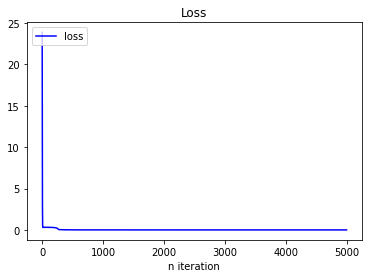

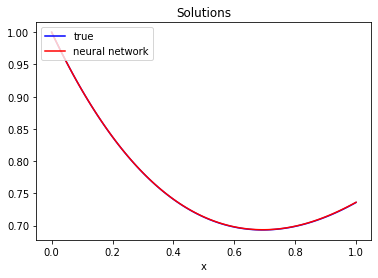

7.36240730837828e-08
Time = 191.11639213562012


In [ ]:
time0 = time()
run_train(lr=0.01, num_e= 5000)
print(f"Time = {time() - time0}")

In [ ]:
def evaluate_np(x_data_np):
    u_hat = []
    for x in x_data_np:
        x_tensor = torch.tensor(np.array([x]), requires_grad= True)
        temp = model(x_tensor.float())
        u_hat.append(temp.clone().item())
    return u_hat

In [ ]:
def evaluate_error_np(x_data_np):
    y_pred = evaluate_np(x_data_np)
    y_true = u_star_func(x_data_np)
    return np.mean(np.square(y_true -  y_pred))

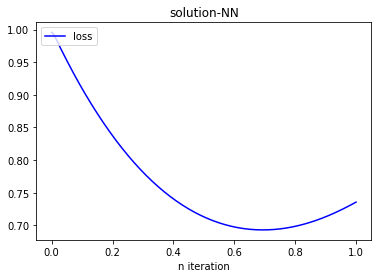

1.1533252484662064e-07

In [ ]:
x_init_np2 = np.arange(start=a, stop=b+step/2, step=step/2)
x_init2 = torch.tensor(x_init_np2, requires_grad= True)
y_pred2 = evaluate_np(x_init_np2)
draw_result(x_init_np2, y_pred2, 'solution-NN')
evaluate_error_np(x_init_np2)

In [ ]:
step_size = []
error = []
for k in [4,6,8,10,12, 14, 26]:
    x_vec = np.arange(start=a, stop=b+step/k, step=step/k)
    y_pred = evaluate_np(x_vec)
    error.append(evaluate_error_np(x_vec))
    step_size.append(step/k)

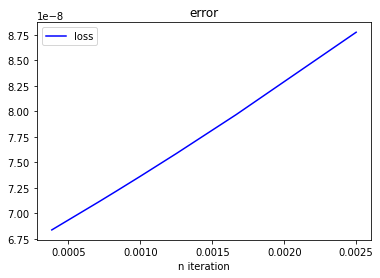

[0.0025, 0.0016666666666666668, 0.00125, 0.001, 0.0008333333333333334, 0.0007142857142857143, 0.0003846153846153846]


In [ ]:
draw_result(step_size[::-1], error[::-1], 'error')
print(step_size)